In [ ]:
# importing libraries
import tensorflow as tf
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.preprocessing import text, sequence
from keras.models import Model, Sequential , load_model
from keras.utils.vis_utils import plot_model
from keras.layers import Dense, Input, LSTM, SimpleRNN, Embedding, Dropout, SpatialDropout1D, Activation, Conv1D,GRU
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, BatchNormalization, Add
from keras.optimizers import Adam
from sklearn.model_selection  import train_test_split
import keras.backend as K
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
sns.set_style("whitegrid")
from IPython.display import Image
import re, string

In [ ]:
df= pd.read_csv("/content/All_Corpora_normalized-2023.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11902 entries, 0 to 11901
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   content       11902 non-null  object
 1   Anger         11902 non-null  int64 
 2   Anticipation  11902 non-null  int64 
 3   Disgust       11902 non-null  int64 
 4   Fear          11902 non-null  int64 
 5   Joy           11902 non-null  int64 
 6   Love          11902 non-null  int64 
 7   Optimism      11902 non-null  int64 
 8   Pessimism     11902 non-null  int64 
 9   Sadness       11902 non-null  int64 
 10  Surprise      11902 non-null  int64 
 11  Trust         11902 non-null  int64 
 12  Neutral       11902 non-null  int64 
dtypes: int64(12), object(1)
memory usage: 1.2+ MB


In [ ]:
df.columns = df.columns.str.strip() # Remove spaces from columns names

In [ ]:
#remove punctuations
def remove_punctuations(tweet):
  sentence = tweet.translate(str.maketrans('', '', string.punctuation))
  return sentence
df['content'] = df['content'].apply(lambda x:remove_punctuations(x))

In [ ]:
rowSums = df.iloc[:,1:].sum(axis=1) # filter rows with all zeros (No label)
df= df.loc[rowSums>0]

In [ ]:
df.drop_duplicates(inplace= True) # drop duplicated rows

In [ ]:
# filter pure numbers in content column:
df['content'] = df['content'].apply(lambda x: ' '.join([word for word in x.split() if not word.isnumeric()]))

In [ ]:
train, test = train_test_split(df, random_state=42, test_size=0.20, shuffle=True)  # Split the data into train and test

In [ ]:
X_train, y_train= train["content"] , train.drop("content",axis = 1)
X_test, y_test= test["content"] , test.drop("content",axis = 1)

In [ ]:
# hyperparameters (Can be modified)
max_features = 20000 # max number of unique words in the embeddinbg vector
max_len = 50 # max number of words in each tweet
embedding_dims = 128 # embedding vector dimension 
num_epochs = 10 # number of times that the model is exposed to the training dataset
val_split = 0.1 # validation set ratio 
batch_size = 256 # number of training examples in one forward/backward pass
lr = 0.01 # learning rate (weigths updating rate)

In [ ]:
#Tokenization
tokenizer =Tokenizer(max_len,lower= False)
tokenizer.fit_on_texts(list(X_train))

#Convert tokenized tweets to sequnces
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
 
# padding the sequences
X_train = pad_sequences(X_train, max_len)
X_test  = pad_sequences(X_test,  max_len)

print('X_train shape:', X_train.shape)
print('X_test shape: ', X_test.shape)

X_train shape: (9474, 50)
X_test shape:  (2369, 50)


In [ ]:
early = EarlyStopping(monitor="val_accuracy", mode="max", patience=5, verbose = True) # Early Stopping to prevent overfitting

**Convolutional Neural Network (CNN)**

In [ ]:
CNN_model = Sequential([
    Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims),
    SpatialDropout1D(0.5), #Spatial 1D version of Dropout.
    Conv1D(filters=100, kernel_size=4, padding='same', activation='relu'), # convolutional layer
    BatchNormalization(), # normalizes the activations of the previous layer at each batch,
    Dropout(0.5), # helps prevent overfitting.
    GlobalMaxPool1D(), # downsamples the input representation
    Dense(50, activation = 'relu'),
    Dense(12, activation = 'sigmoid')
])

In [ ]:
CNN_model.summary() # Visualize the CNN MODEL Architecture

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 128)           2560000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 128)          0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 50, 100)           51300     
                                                                 
 batch_normalization (BatchN  (None, 50, 100)          400       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0

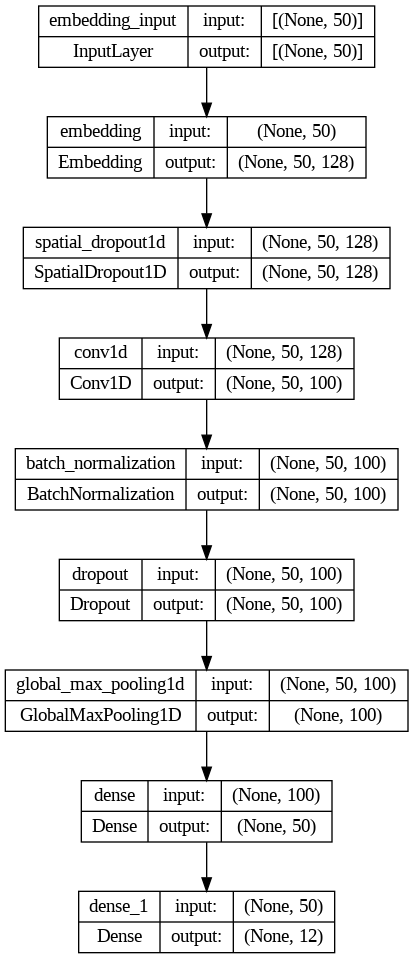

In [ ]:
#Plot the Model architecture
plot_model(CNN_model, to_file='CNN_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='CNN_model_plot.png')

In [ ]:
CNN_model.compile(loss='binary_crossentropy', optimizer=Adam(lr), metrics=['accuracy'])

In [ ]:
model_checkpoint = ModelCheckpoint(
    filepath = 'saved_models/CNN_model.h5',                                      
    save_weights_only = False,
    monitor = 'val_accuracy',
    mode = 'max',
    verbose = 1,
    save_best_only = True)

In [ ]:
CNN_model_fit = CNN_model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[model_checkpoint,early])

Epoch 1/10
37/38 [============================>.] - ETA: 0s - loss: 0.1339 - accuracy: 0.6564
Epoch 1: val_accuracy did not improve from 0.71802
38/38 [==============================] - 1s 37ms/step - loss: 0.1339 - accuracy: 0.6563 - val_loss: 0.1452 - val_accuracy: 0.6323
Epoch 2/10
37/38 [============================>.] - ETA: 0s - loss: 0.1350 - accuracy: 0.6630
Epoch 2: val_accuracy did not improve from 0.71802
38/38 [==============================] - 1s 37ms/step - loss: 0.1349 - accuracy: 0.6631 - val_loss: 0.1334 - val_accuracy: 0.6230
Epoch 3/10
37/38 [============================>.] - ETA: 0s - loss: 0.1329 - accuracy: 0.6510
Epoch 3: val_accuracy did not improve from 0.71802
38/38 [==============================] - 1s 37ms/step - loss: 0.1329 - accuracy: 0.6510 - val_loss: 0.1327 - val_accuracy: 0.6758
Epoch 4/10
37/38 [============================>.] - ETA: 0s - loss: 0.1310 - accuracy: 0.6760
Epoch 4: val_accuracy did not improve from 0.71802
38/38 [=======================

In [ ]:
CNN_model = load_model('/content/saved_models/CNN_model.h5')

In [ ]:
# Evaluate the CNN Model accuracy on train data
CNN_train_score = CNN_model.evaluate(X_train, y_train, batch_size=batch_size, verbose = 1)
print('Train loss of CNN Model:', CNN_train_score[0])
print('Train accuracy of CNN Model:', CNN_train_score[1])
# Evaluate the CNN Model accuracy on test data
CNN_test_score = CNN_model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
print('Test Loss of CNN Model:', CNN_test_score[0])
print('Test Accuracy of CNN Model:', CNN_test_score[1])

38/38 [==============================] - 0s 6ms/step - loss: 0.2972 - accuracy: 0.7366
Train loss of CNN Model: 0.2972431778907776
Train accuracy of CNN Model: 0.7366476655006409
10/10 [==============================] - 0s 7ms/step - loss: 0.3005 - accuracy: 0.7180
Test Loss of CNN Model: 0.3004513382911682
Test Accuracy of CNN Model: 0.718024492263794


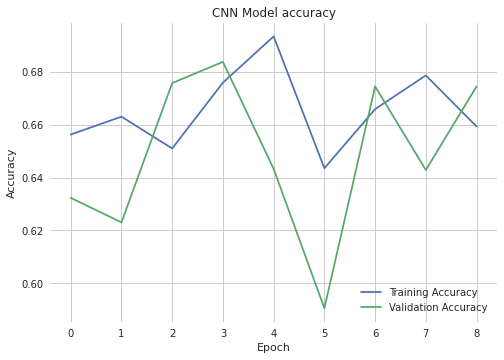

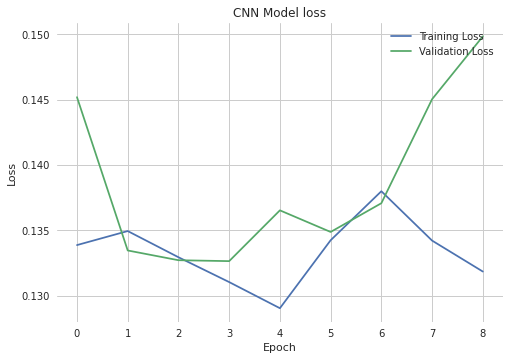

In [ ]:
# Plot training & validation accuracy values
plt.plot(CNN_model_fit.history['accuracy'])
plt.plot(CNN_model_fit.history['val_accuracy'])
plt.title('CNN Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(CNN_model_fit.history['loss'])
plt.plot(CNN_model_fit.history['val_loss'])
plt.title('CNN Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

**Recurrent Neural Network (RNN)**

In [ ]:
RNN_model = Sequential([
    Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims),
    SpatialDropout1D(0.5),
    SimpleRNN(25, return_sequences=True), 
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu'),
    Dense(12, activation = 'sigmoid')
])

In [ ]:
RNN_model.summary() # Visualize the RNN MODEL Architecture

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 128)           2560000   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 50, 128)          0         
 lDropout1D)                                                     
                                                                 
 simple_rnn (SimpleRNN)      (None, 50, 25)            3850      
                                                                 
 batch_normalization_1 (Batc  (None, 50, 25)           100       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 50, 25)            0         
                                                                 
 global_max_pooling1d_1 (Glo  (None, 25)              

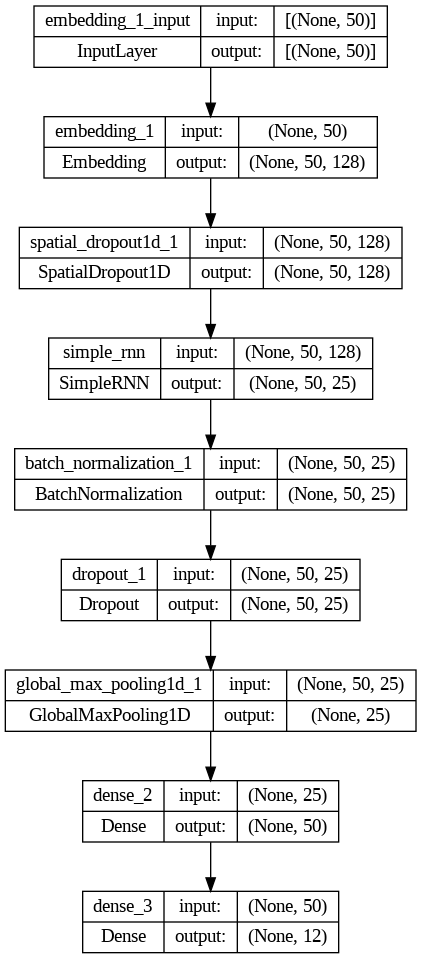

In [ ]:
#Plot the Model architecture
plot_model(RNN_model, to_file='RNN_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='RNN_model_plot.png')

In [ ]:
RNN_model.compile(loss='binary_crossentropy', optimizer=Adam(lr), metrics=['accuracy'])

In [ ]:
model_checkpoint = ModelCheckpoint(
    filepath = 'saved_models/RNN_model.h5',                                      
    save_weights_only = False,
    monitor = 'val_accuracy',
    mode = 'max',
    verbose = 1,
    save_best_only = True)

In [ ]:
RNN_model_fit = RNN_model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[model_checkpoint,early])

Epoch 1/10
37/38 [============================>.] - ETA: 0s - loss: 0.1500 - accuracy: 0.6240
Epoch 1: val_accuracy did not improve from 0.69354
38/38 [==============================] - 1s 33ms/step - loss: 0.1500 - accuracy: 0.6241 - val_loss: 0.2194 - val_accuracy: 0.5762
Epoch 2/10
37/38 [============================>.] - ETA: 0s - loss: 0.1520 - accuracy: 0.6186
Epoch 2: val_accuracy did not improve from 0.69354
38/38 [==============================] - 1s 30ms/step - loss: 0.1520 - accuracy: 0.6186 - val_loss: 0.2362 - val_accuracy: 0.5766
Epoch 3/10
37/38 [============================>.] - ETA: 0s - loss: 0.1525 - accuracy: 0.6262
Epoch 3: val_accuracy did not improve from 0.69354
38/38 [==============================] - 1s 30ms/step - loss: 0.1525 - accuracy: 0.6262 - val_loss: 0.2523 - val_accuracy: 0.5758
Epoch 4/10
37/38 [============================>.] - ETA: 0s - loss: 0.1545 - accuracy: 0.5955
Epoch 4: val_accuracy did not improve from 0.69354
38/38 [=======================

In [ ]:
RNN_model = load_model('/content/saved_models/RNN_model.h5')

In [ ]:
# Evaluate the RNN Model accuracy on train data
RNN_train_score = RNN_model.evaluate(X_train, y_train, batch_size=batch_size, verbose = 1)
print('Train loss of RNN Model:', RNN_train_score[0])
print('Train accuracy of RNN Model:', RNN_train_score[1])
# Evaluate the RNN Model accuracy on test data
RNN_test_score = RNN_model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
print('Test Loss of RNN Model:', RNN_test_score[0])
print('Test Accuracy of RNN Model:', RNN_test_score[1])

38/38 [==============================] - 1s 9ms/step - loss: 0.3530 - accuracy: 0.7007
Train loss of RNN Model: 0.35303807258605957
Train accuracy of RNN Model: 0.7006544470787048
10/10 [==============================] - 0s 9ms/step - loss: 0.3553 - accuracy: 0.6935
Test Loss of RNN Model: 0.3553253710269928
Test Accuracy of RNN Model: 0.6935415863990784


**Bidirectional Recurrent Neural Network (Bi-RNN)**

In [ ]:
Bi_RNN_model = Sequential([
    Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims),
    SpatialDropout1D(0.5),
    Bidirectional(SimpleRNN(25, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu'),
    Dense(12, activation = 'sigmoid')
])

In [ ]:
Bi_RNN_model.summary() # Visualize the Bi_RNN MODEL Architecture

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 128)           2560000   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 50, 128)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional (Bidirectiona  (None, 50, 50)           7700      
 l)                                                              
                                                                 
 batch_normalization_2 (Batc  (None, 50, 50)           200       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 50, 50)            0         
                                                      

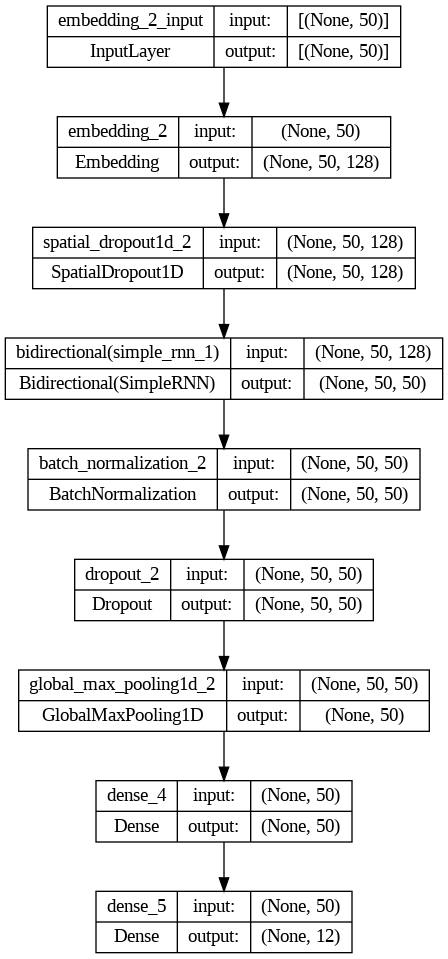

In [ ]:
#Plot the Model architecture
plot_model(Bi_RNN_model, to_file='Bi_RNN_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='Bi_RNN_model_plot.png')

In [ ]:
Bi_RNN_model.compile(loss='binary_crossentropy', optimizer=Adam(lr), metrics=['accuracy'])

In [ ]:
model_checkpoint = ModelCheckpoint(
    filepath = 'saved_models/Bi_RNN_model.h5',                                      
    save_weights_only = False,
    monitor = 'val_accuracy',
    mode = 'max',
    verbose = 1,
    save_best_only = True)

In [ ]:
Bi_RNN_model_fit = Bi_RNN_model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[model_checkpoint,early])

Epoch 1/10
37/38 [============================>.] - ETA: 0s - loss: 0.1407 - accuracy: 0.6351
Epoch 1: val_accuracy did not improve from 0.73111
38/38 [==============================] - 1s 39ms/step - loss: 0.1408 - accuracy: 0.6352 - val_loss: 0.1656 - val_accuracy: 0.6230
Epoch 2/10
37/38 [============================>.] - ETA: 0s - loss: 0.1444 - accuracy: 0.6434
Epoch 2: val_accuracy did not improve from 0.73111
38/38 [==============================] - 1s 39ms/step - loss: 0.1444 - accuracy: 0.6433 - val_loss: 0.1791 - val_accuracy: 0.6180
Epoch 3/10
37/38 [============================>.] - ETA: 0s - loss: 0.1390 - accuracy: 0.6141
Epoch 3: val_accuracy did not improve from 0.73111
38/38 [==============================] - 2s 40ms/step - loss: 0.1390 - accuracy: 0.6140 - val_loss: 0.1604 - val_accuracy: 0.6830
Epoch 4/10
37/38 [============================>.] - ETA: 0s - loss: 0.1504 - accuracy: 0.6326
Epoch 4: val_accuracy did not improve from 0.73111
38/38 [=======================

In [ ]:
Bi_RNN_model = load_model('/content/saved_models/Bi_RNN_model.h5')

In [ ]:
# Evaluate the Bi_RNN Model accuracy on train data
Bi_RNN_train_score = Bi_RNN_model.evaluate(X_train, y_train, batch_size=batch_size, verbose = 1)
print('Train loss of Bi_RNN Model:', Bi_RNN_train_score[0])
print('Train accuracy of Bi_RNN Model:', Bi_RNN_train_score[1])
# Evaluate the Bi_RNN Model accuracy on test data
Bi_RNN_test_score = Bi_RNN_model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
print('Test Loss of Bi_RNN Model:', Bi_RNN_test_score[0])
print('Test Accuracy of Bi_RNN Model:', Bi_RNN_test_score[1])

38/38 [==============================] - 1s 10ms/step - loss: 0.1415 - accuracy: 0.7445
Train loss of Bi_RNN Model: 0.14152610301971436
Train accuracy of Bi_RNN Model: 0.7444584965705872
10/10 [==============================] - 0s 10ms/step - loss: 0.1480 - accuracy: 0.7311
Test Loss of Bi_RNN Model: 0.14803344011306763
Test Accuracy of Bi_RNN Model: 0.731110155582428


**Long Short-Term Memory (LSTM)**

In [ ]:
LSTM_model = Sequential([
    Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims),
    SpatialDropout1D(0.5),
    LSTM(25, return_sequences=True),
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu'),
    Dense(12, activation = 'sigmoid')
])

In [ ]:
LSTM_model.compile(loss='binary_crossentropy', optimizer=Adam(lr), metrics=['accuracy'])
LSTM_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 128)           2560000   
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 50, 128)          0         
 lDropout1D)                                                     
                                                                 
 lstm (LSTM)                 (None, 50, 25)            15400     
                                                                 
 batch_normalization_3 (Batc  (None, 50, 25)           100       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 50, 25)            0         
                                                                 
 global_max_pooling1d_3 (Glo  (None, 25)              

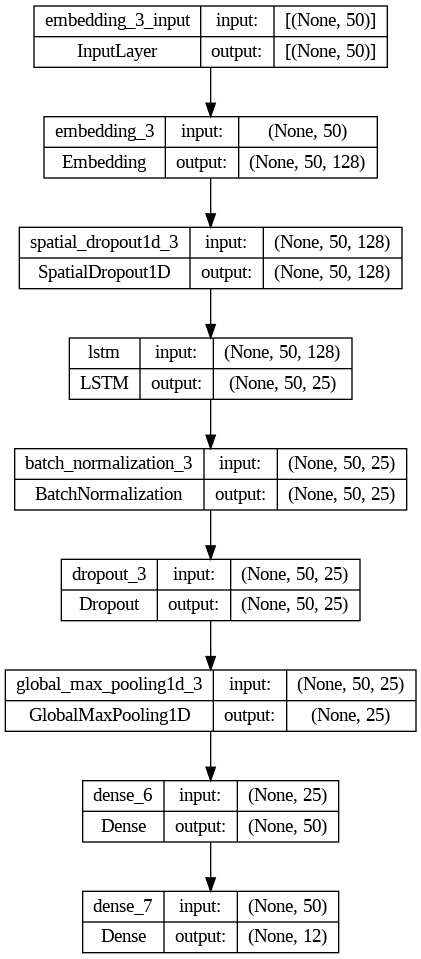

In [ ]:
#Plot the Model architecture
plot_model(LSTM_model, to_file='LSTM_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='LSTM_model_plot.png')

In [ ]:
model_checkpoint = ModelCheckpoint(
    filepath = 'saved_models/LSTM_model.h5',                                      
    save_weights_only = False,
    monitor = 'val_accuracy',
    mode = 'max',
    verbose = 1,
    save_best_only = True)

In [ ]:
LSTM_model_fit = LSTM_model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_split=val_split, callbacks=[model_checkpoint,early])

Epoch 1/10
33/34 [============================>.] - ETA: 0s - loss: 0.1378 - accuracy: 0.6455
Epoch 1: val_accuracy did not improve from 0.74473
34/34 [==============================] - 2s 58ms/step - loss: 0.1375 - accuracy: 0.6452 - val_loss: 0.1953 - val_accuracy: 0.6245
Epoch 2/10
33/34 [============================>.] - ETA: 0s - loss: 0.1373 - accuracy: 0.6523
Epoch 2: val_accuracy did not improve from 0.74473
34/34 [==============================] - 2s 56ms/step - loss: 0.1371 - accuracy: 0.6534 - val_loss: 0.1736 - val_accuracy: 0.6255
Epoch 3/10
33/34 [============================>.] - ETA: 0s - loss: 0.1362 - accuracy: 0.6523
Epoch 3: val_accuracy did not improve from 0.74473
34/34 [==============================] - 2s 59ms/step - loss: 0.1362 - accuracy: 0.6521 - val_loss: 0.1646 - val_accuracy: 0.6603
Epoch 4/10
33/34 [============================>.] - ETA: 0s - loss: 0.1356 - accuracy: 0.6773
Epoch 4: val_accuracy did not improve from 0.74473
34/34 [=======================

In [ ]:
LSTM_model = load_model('/content/saved_models/LSTM_model.h5')

In [ ]:
# Evaluate the LSTM Model accuracy on train data
LSTM_train_score = LSTM_model.evaluate(X_train, y_train, batch_size=batch_size, verbose = 1)
print('Train loss of LSTM Model:', LSTM_train_score[0])
print('Train accuracy of LSTM Model:', LSTM_train_score[1])
# Evaluate the LSTM Model accuracy on test data
LSTM_test_score = LSTM_model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
print('Test Loss of LSTM Model:', LSTM_test_score[0])
print('Test Accuracy of LSTM Model:', LSTM_test_score[1])

38/38 [==============================] - 1s 19ms/step - loss: 0.1441 - accuracy: 0.7497
Train loss of LSTM Model: 0.14406871795654297
Train accuracy of LSTM Model: 0.7497361302375793
10/10 [==============================] - 0s 17ms/step - loss: 0.1510 - accuracy: 0.7320
Test Loss of LSTM Model: 0.15104953944683075
Test Accuracy of LSTM Model: 0.7319543957710266


**Bidirectional Long Short_Term Memory (Bidirectional LSTM)**

In [ ]:
Bi_LSTM_model = Sequential([
    Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims),
    SpatialDropout1D(0.5),
    Bidirectional(LSTM(25, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu'),
    Dense(12, activation = 'sigmoid')
])

In [ ]:
Bi_LSTM_model.compile(loss='binary_crossentropy', optimizer=Adam(lr), metrics=['accuracy'])
Bi_LSTM_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 128)           2560000   
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 50, 128)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_1 (Bidirectio  (None, 50, 50)           30800     
 nal)                                                            
                                                                 
 batch_normalization_4 (Batc  (None, 50, 50)           200       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 50, 50)            0         
                                                      

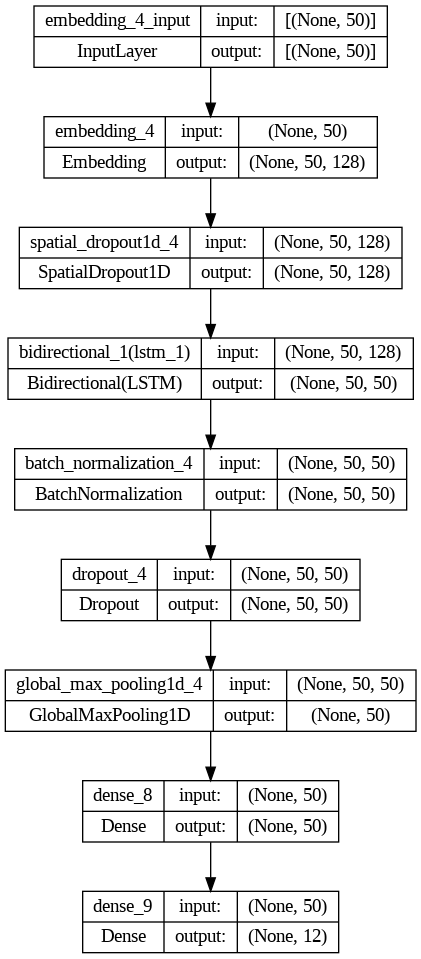

In [ ]:
#Plot the Model architecture
plot_model(Bi_LSTM_model, to_file='Bi_LSTM_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='Bi_LSTM_model_plot.png')

In [ ]:
model_checkpoint = ModelCheckpoint(
    filepath = 'saved_models/Bi_LSTM_model.h5',                                      
    save_weights_only = False,
    monitor = 'val_accuracy',
    mode = 'max',
    verbose = 1,
    save_best_only = True)

In [ ]:
Bi_LSTM_model_fit = Bi_LSTM_model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_split=val_split, callbacks=[model_checkpoint,early])

Epoch 1/10
33/34 [============================>.] - ETA: 0s - loss: 0.1127 - accuracy: 0.7071
Epoch 1: val_accuracy did not improve from 0.75422
34/34 [==============================] - 2s 70ms/step - loss: 0.1125 - accuracy: 0.7070 - val_loss: 0.1276 - val_accuracy: 0.6466
Epoch 2/10
33/34 [============================>.] - ETA: 0s - loss: 0.1120 - accuracy: 0.7040
Epoch 2: val_accuracy did not improve from 0.75422
34/34 [==============================] - 2s 70ms/step - loss: 0.1124 - accuracy: 0.7033 - val_loss: 0.1267 - val_accuracy: 0.6741
Epoch 3/10
33/34 [============================>.] - ETA: 0s - loss: 0.1130 - accuracy: 0.6870
Epoch 3: val_accuracy did not improve from 0.75422
34/34 [==============================] - 2s 68ms/step - loss: 0.1130 - accuracy: 0.6868 - val_loss: 0.1284 - val_accuracy: 0.6561
Epoch 4/10
33/34 [============================>.] - ETA: 0s - loss: 0.1115 - accuracy: 0.6933
Epoch 4: val_accuracy did not improve from 0.75422
34/34 [=======================

In [ ]:
Bi_LSTM_model = load_model('/content/saved_models/Bi_LSTM_model.h5')

In [ ]:
# Evaluate the Bi_LSTM Model accuracy on train data
Bi_LSTM_train_score = Bi_LSTM_model.evaluate(X_train, y_train, batch_size=batch_size, verbose = 1)
print('Train loss of Bi_LSTM Model:', Bi_LSTM_train_score[0])
print('Train accuracy of Bi_LSTM Model:', Bi_LSTM_train_score[1])
# Evaluate the Bi_LSTM Model accuracy on test data
Bi_LSTM_test_score = Bi_LSTM_model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
print('Test Loss of Bi_LSTM Model:', Bi_LSTM_test_score[0])
print('Test Accuracy of Bi_LSTM Model:', Bi_LSTM_test_score[1])

38/38 [==============================] - 2s 23ms/step - loss: 0.1176 - accuracy: 0.7705
Train loss of Bi_LSTM Model: 0.11758105456829071
Train accuracy of Bi_LSTM Model: 0.7705298662185669
10/10 [==============================] - 0s 22ms/step - loss: 0.1363 - accuracy: 0.7429
Test Loss of Bi_LSTM Model: 0.13634584844112396
Test Accuracy of Bi_LSTM Model: 0.7429295182228088


**Gated Recurrent Unit (GRU)**

In [ ]:
GRU_model= Sequential([
    Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims),
    SpatialDropout1D(0.5),
    GRU(128, return_sequences=True,dropout=0.1,recurrent_dropout=0.1),
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu'),
    Dense(12, activation = 'sigmoid')
])

In [ ]:
GRU_model.compile(loss='binary_crossentropy',optimizer=Adam(lr),metrics=['accuracy'])
GRU_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 128)           2560000   
                                                                 
 spatial_dropout1d_5 (Spatia  (None, 50, 128)          0         
 lDropout1D)                                                     
                                                                 
 gru (GRU)                   (None, 50, 128)           99072     
                                                                 
 batch_normalization_5 (Batc  (None, 50, 128)          512       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 50, 128)           0         
                                                                 
 global_max_pooling1d_5 (Glo  (None, 128)             

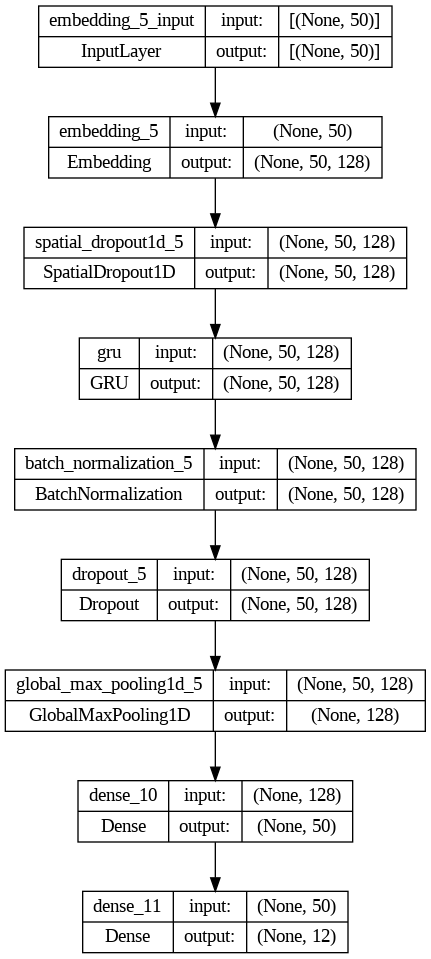

In [ ]:
#Plot the Model architecture
plot_model(GRU_model, to_file='GRU_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='GRU_model_plot.png')

In [ ]:
model_checkpoint = ModelCheckpoint(
    filepath = 'saved_models/GRU_model.h5',                                      
    save_weights_only = False,
    monitor = 'val_accuracy',
    mode = 'max',
    verbose = 1,
    save_best_only = True)

In [ ]:
GRU_model_fit = GRU_model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_split=val_split, callbacks=[model_checkpoint,early])

Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 0.1231 - accuracy: 0.6800
Epoch 1: val_accuracy did not improve from 0.74789
34/34 [==============================] - 5s 141ms/step - loss: 0.1231 - accuracy: 0.6800 - val_loss: 0.1343 - val_accuracy: 0.6498
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 0.1211 - accuracy: 0.6878
Epoch 2: val_accuracy did not improve from 0.74789
34/34 [==============================] - 5s 142ms/step - loss: 0.1211 - accuracy: 0.6878 - val_loss: 0.1256 - val_accuracy: 0.6572
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 0.1213 - accuracy: 0.6877
Epoch 3: val_accuracy did not improve from 0.74789
34/34 [==============================] - 5s 139ms/step - loss: 0.1213 - accuracy: 0.6877 - val_loss: 0.1236 - val_accuracy: 0.6013
Epoch 4/10
34/34 [==============================] - ETA: 0s - loss: 0.1216 - accuracy: 0.6872
Epoch 4: val_accuracy did not improve from 0.74789
34/34 [====================

In [ ]:
GRU_model = load_model('/content/saved_models/GRU_model.h5')

In [ ]:
# Evaluate the GRU Model accuracy on train data
GRU_train_score = GRU_model.evaluate(X_train, y_train, batch_size=batch_size, verbose = 1)
print('Train loss of GRU Model:', GRU_train_score[0])
print('Train accuracy of GRU Model:', GRU_train_score[1])
# Evaluate the GRU Model accuracy on test data
GRU_test_score = GRU_model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
print('Test Loss of GRU Model:', GRU_test_score[0])
print('Test Accuracy of GRU Model:', GRU_test_score[1])

38/38 [==============================] - 2s 39ms/step - loss: 0.1989 - accuracy: 0.7542
Train loss of GRU Model: 0.19888043403625488
Train accuracy of GRU Model: 0.7541692852973938
10/10 [==============================] - 0s 38ms/step - loss: 0.2039 - accuracy: 0.7332
Test Loss of GRU Model: 0.2039378434419632
Test Accuracy of GRU Model: 0.7332207560539246


**Bidirectional Gated Recurrent Unit (Bidirecitonal GRU)**

In [ ]:
Bi_GRU_model= Sequential([
    Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims),
    SpatialDropout1D(0.5),
    Bidirectional(GRU(128, return_sequences=True,dropout=0.1,recurrent_dropout=0.1)),
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu'),
    Dense(12, activation = 'sigmoid')
])

In [ ]:
Bi_GRU_model.compile(loss='binary_crossentropy',optimizer=Adam(lr),metrics=['accuracy'])
Bi_GRU_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 50, 128)           2560000   
                                                                 
 spatial_dropout1d_6 (Spatia  (None, 50, 128)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 256)          198144    
 nal)                                                            
                                                                 
 batch_normalization_6 (Batc  (None, 50, 256)          1024      
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 50, 256)           0         
                                                      

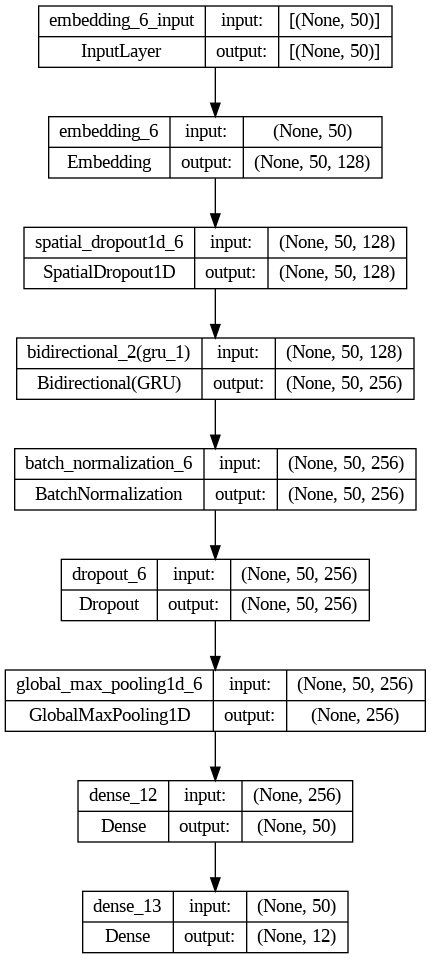

In [ ]:
#Plot the Model architecture
plot_model(Bi_GRU_model, to_file='Bi_GRU_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='Bi_GRU_model_plot.png')

In [ ]:
model_checkpoint = ModelCheckpoint(
    filepath = 'saved_models/Bi_GRU_model.h5',                                      
    save_weights_only = False,
    monitor = 'val_accuracy',
    mode = 'max',
    verbose = 1,
    save_best_only = True)

In [ ]:
Bi_GRU_model_fit = Bi_GRU_model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_split=val_split, callbacks=[model_checkpoint,early])

Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 0.1047 - accuracy: 0.6909
Epoch 1: val_accuracy did not improve from 0.70992
34/34 [==============================] - 6s 169ms/step - loss: 0.1047 - accuracy: 0.6909 - val_loss: 0.1720 - val_accuracy: 0.6234
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 0.1056 - accuracy: 0.7098
Epoch 2: val_accuracy did not improve from 0.70992
34/34 [==============================] - 6s 172ms/step - loss: 0.1056 - accuracy: 0.7098 - val_loss: 0.1603 - val_accuracy: 0.6044
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 0.1056 - accuracy: 0.6982
Epoch 3: val_accuracy did not improve from 0.70992
34/34 [==============================] - 6s 166ms/step - loss: 0.1056 - accuracy: 0.6982 - val_loss: 0.1876 - val_accuracy: 0.5970
Epoch 4/10
34/34 [==============================] - ETA: 0s - loss: 0.1046 - accuracy: 0.7162
Epoch 4: val_accuracy did not improve from 0.70992
34/34 [====================

In [ ]:
Bi_GRU_model = load_model('/content/saved_models/Bi_GRU_model.h5')

In [ ]:
# Evaluate the Bi_GRU Model accuracy on train data
Bi_GRU_train_score = Bi_GRU_model.evaluate(X_train, y_train, batch_size=batch_size, verbose = 1)
print('Train loss of Bi_GRU Model:', Bi_GRU_train_score[0])
print('Train accuracy of Bi_GRU Model:', Bi_GRU_train_score[1])
# Evaluate the Bi_GRU Model accuracy on test data
Bi_GRU_test_score = Bi_GRU_model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
print('Test Loss of Bi_GRU Model:', Bi_GRU_test_score[0])
print('Test Accuracy of Bi_GRU Model:', Bi_GRU_test_score[1])

38/38 [==============================] - 2s 42ms/step - loss: 0.1631 - accuracy: 0.7341
Train loss of Bi_GRU Model: 0.16310252249240875
Train accuracy of Bi_GRU Model: 0.734114408493042
10/10 [==============================] - 0s 42ms/step - loss: 0.1721 - accuracy: 0.7172
Test Loss of Bi_GRU Model: 0.1721302568912506
Test Accuracy of Bi_GRU Model: 0.7171802520751953
